In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tabulate import tabulate

# Configure plots
plt.style.use("seaborn-v0_8")
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("--- Initializing Clustering Environment ---")

## 1. Data Loading and Preparation 💾
PROJECT_ROOT = Path().resolve().parents[0] if len(Path().resolve().parents) > 1 else Path().resolve()
DATA_PROCESSED = PROJECT_ROOT / "Data" / "processed"

# Fallback path check
if not (DATA_PROCESSED / "train_clean.csv").exists():
    print(f"ERROR: train_clean.csv not found at {DATA_PROCESSED}. Checking current directory.")
    DATA_PROCESSED = Path().resolve()

# Load cleaned data
dtype_map = {"StateHoliday": "string", "PromoInterval": "string"}
try:
    train = pd.read_csv(DATA_PROCESSED / "train_clean.csv", dtype=dtype_map)
except FileNotFoundError:
    print("\nFATAL ERROR: Could not load 'train_clean.csv'. Check your directory structure.")
    exit()

# Ensure Date column is datetime
train["Date"] = pd.to_datetime(train["Date"])
print("Loaded processed training dataset.")


# --- Apply Clipping (1%-99% percentile) for Outlier Mitigation ---
def clip_percentile(series, lower_q=0.01, upper_q=0.99):
    lower = series.quantile(lower_q)
    upper = series.quantile(upper_q)
    return series.clip(lower, upper)


numeric_cols = train.select_dtypes(include=["number"]).columns.tolist()
cols_to_clip = [col for col in numeric_cols if
                col not in ["Store", "Date", "DayOfWeek", "Year", "Month", "Day", "WeekOfYear"]]

train_clipped_p99 = train.copy()
for col in cols_to_clip:
    train_clipped_p99[col] = clip_percentile(train_clipped_p99[col])
print("Applied 1%-99% percentile clipping to key numerical features.")

--- Initializing Clustering Environment ---
Loaded processed training dataset.
Applied 1%-99% percentile clipping to key numerical features.


In [2]:
## 2. Feature Aggregation, Imputation, and Scaling 🛠️

# Aggregating key operational metrics per Store, using clipped data
store_data = (
    train_clipped_p99.groupby("Store")
    .agg(
        Sales=("Sales", "mean"),
        Customers=("Customers", "mean"),
        CompetitionDistance=("CompetitionDistance", "mean"),
        PromoUsage=("Promo", "mean"),
        StoreType=("StoreType", "first"),
        Assortment=("Assortment", "first"),
        State=("State", "first"),
        Promo2=("Promo2", "first"),
    )
    .reset_index()
)

# Calculate SalesPerCustomer after aggregation
store_data["SalesPerCustomer"] = store_data["Sales"] / store_data["Customers"]
store_data["SalesPerCustomer"] = store_data["SalesPerCustomer"].replace([np.inf, -np.inf], np.nan)

# Features selected for clustering (must be numerical)
clustering_features = [
    "Sales",
    "Customers",
    "SalesPerCustomer",
    "CompetitionDistance",
    "PromoUsage",
    "Promo2",
]

# Impute NaNs using the median
imputer = SimpleImputer(strategy='median')
store_data[clustering_features] = imputer.fit_transform(store_data[clustering_features])
print("NaNs imputed using median strategy.")

# Scaling Numerical Features
scaler = StandardScaler()
store_data_scaled = scaler.fit_transform(store_data[clustering_features])
print("Numerical features scaled using StandardScaler.")

NaNs imputed using median strategy.
Numerical features scaled using StandardScaler.


Running K-Means for K=1 to K=10 to find the optimal number of clusters...


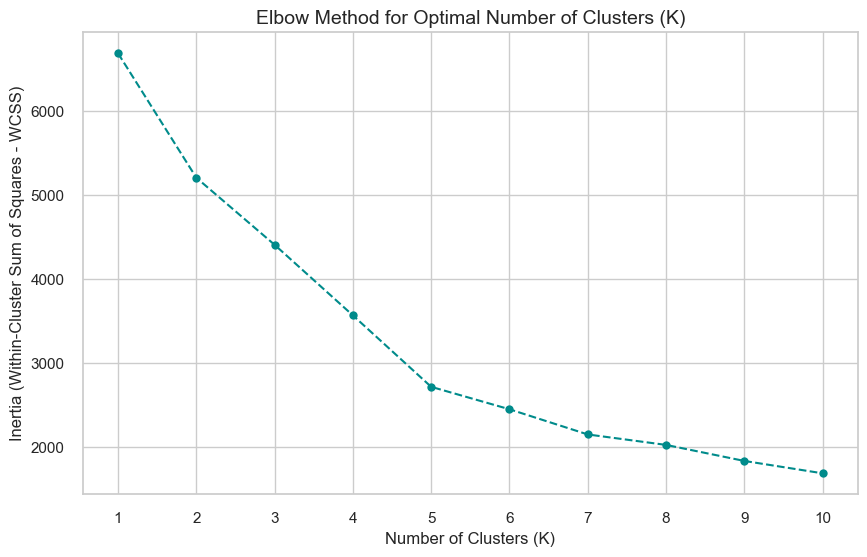

The 'elbow' point is where the decrease in WCSS slows down, suggesting a good trade-off. We will analyze K=3 and K=5.


In [3]:
## 3. Determine Optimal K (Elbow Method) 📏
print("Running K-Means for K=1 to K=10 to find the optimal number of clusters...")

inertia = []
k_range = range(1, 11)

for k in k_range:
    # Set a fixed random_state for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', max_iter=300)
    kmeans.fit(store_data_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method Results
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker="o", linestyle="--", color='darkcyan')
plt.title("Elbow Method for Optimal Number of Clusters (K)", fontsize=14)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares - WCSS)")
plt.xticks(k_range)
plt.grid(True)
plt.show()

print(
    "The 'elbow' point is where the decrease in WCSS slows down, suggesting a good trade-off. We will analyze K=3 and K=5.")



### K-Means Clustering with K=3

--- Cluster Profiles (K=3) ---
| Cluster_3   | Sales   | Customers   | SalesPerCustomer   | CompetitionDistance   | PromoUsage   | Promo2   | StoreType   | State   |
|:------------|:--------|:------------|:-------------------|:----------------------|:-------------|:---------|:------------|:--------|
| 0           | 4998.92 | 482.93      | 10.52              | 3547.68               | 0.38         | 0.94     | a           | BY      |
| 1           | 5735.36 | 550.18      | 10.51              | 17974.6               | 0.38         | 0.24     | a           | SH      |
| 2           | 6493.5  | 797.42      | 8.39               | 2067.94               | 0.38         | 0.17     | a           | NW      |


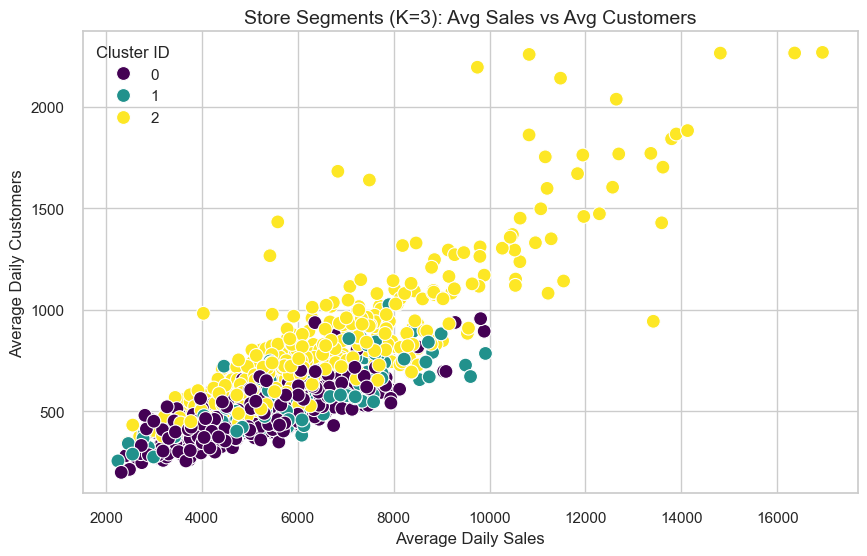


### K-Means Clustering with K=5 (Alternative Model)

--- Cluster Profiles (K=5) ---
| Cluster_5   | Sales   | Customers   | SalesPerCustomer   | CompetitionDistance   | PromoUsage   | Promo2   | StoreType   | State   |
|:------------|:--------|:------------|:-------------------|:----------------------|:-------------|:---------|:------------|:--------|
| 0           | 5158.43 | 538.87      | 9.86               | 3228.18               | 0.38         | 1        | a           | NW      |
| 1           | 5810.41 | 560.86      | 10.48              | 19867                 | 0.38         | 0.29     | a           | SH      |
| 2           | 5420.54 | 612.76      | 8.98               | 2840.74               | 0.38         | 0        | a           | NW      |
| 3           | 9800.69 | 1314.4      | 7.67               | 1366.63               | 0.38         | 0.26     | a           | BE      |
| 4           | 5303.09 | 498.96      | 10.89              | 4108.85               | 0.38         | 0.89 

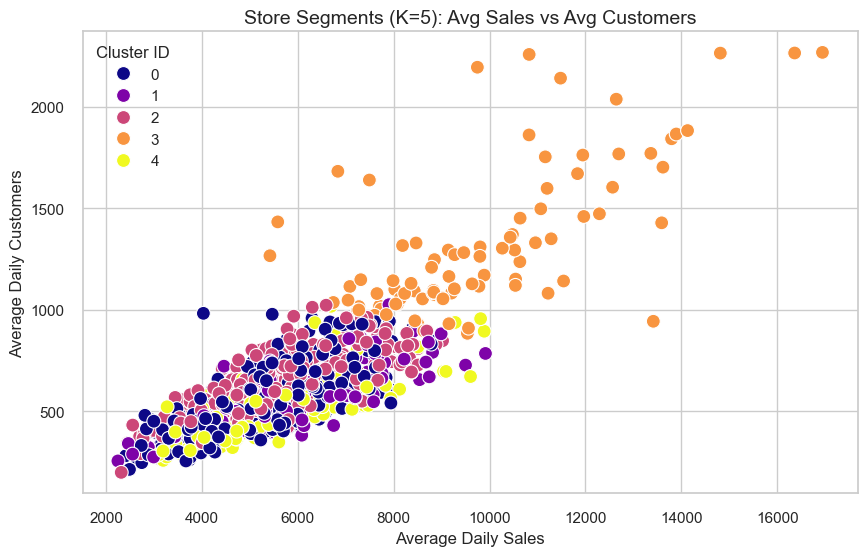

In [4]:
## 4. K-Means Clustering and Analysis 💡

# 4a. Clustering with K=3 (Optimal based on typical elbow observation)
K_3 = 3
print(f"\n### K-Means Clustering with K={K_3}")
kmeans_3 = KMeans(n_clusters=K_3, random_state=42, n_init='auto', max_iter=300)
store_data[f"Cluster_{K_3}"] = kmeans_3.fit_predict(store_data_scaled)

# Cluster Analysis (K=3) - Mean of UN-SCALED features for easy interpretation
cluster_profiles_3 = store_data.groupby(f"Cluster_{K_3}")[clustering_features + ["StoreType", "State"]].agg({
    **{f: 'mean' for f in clustering_features},
    "StoreType": lambda x: x.mode()[0],
    "State": lambda x: x.mode()[0],
}).round(2)

print(f"\n--- Cluster Profiles (K={K_3}) ---")
print(tabulate(cluster_profiles_3, headers='keys', tablefmt='pipe', numalign="left"))

# Visualization of K=3
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=store_data,
    x="Sales",
    y="Customers",
    hue=f"Cluster_{K_3}",
    palette="viridis",
    s=100,
)
plt.title(f"Store Segments (K={K_3}): Avg Sales vs Avg Customers", fontsize=14)
plt.xlabel("Average Daily Sales")
plt.ylabel("Average Daily Customers")
plt.legend(title="Cluster ID")
plt.grid(True)
plt.show()

# 4b. Clustering with K=5 (Demonstrating different parameters)
K_5 = 5
print(f"\n### K-Means Clustering with K={K_5} (Alternative Model)")
kmeans_5 = KMeans(n_clusters=K_5, random_state=42, n_init='auto', max_iter=300)
store_data[f"Cluster_{K_5}"] = kmeans_5.fit_predict(store_data_scaled)

# Cluster Analysis (K=5) - Mean of UN-SCALED features
cluster_profiles_5 = store_data.groupby(f"Cluster_{K_5}")[clustering_features + ["StoreType", "State"]].agg({
    **{f: 'mean' for f in clustering_features},
    "StoreType": lambda x: x.mode()[0],
    "State": lambda x: x.mode()[0],
}).round(2)

print(f"\n--- Cluster Profiles (K={K_5}) ---")
print(tabulate(cluster_profiles_5, headers='keys', tablefmt='pipe', numalign="left"))

# Visualization of K=5
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=store_data,
    x="Sales",
    y="Customers",
    hue=f"Cluster_{K_5}",
    palette="plasma",
    s=100,
)
plt.title(f"Store Segments (K={K_5}): Avg Sales vs Avg Customers", fontsize=14)
plt.xlabel("Average Daily Sales")
plt.ylabel("Average Daily Customers")
plt.legend(title="Cluster ID")
plt.grid(True)
plt.show()



In [5]:
## 5. Exporting Results 📤

print("\n## 5. Exporting Results to CSV Files")

# Create Output directory if it doesn't exist
OUTPUT_DIR = PROJECT_ROOT / "Output"
OUTPUT_DIR.mkdir(exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

output_features = ["Store", "StoreType", "Assortment", "State"] + clustering_features + [f"Cluster_{K_3}",
                                                                                         f"Cluster_{K_5}"]

# 1. Export the store-level data with cluster assignments
store_data_output = store_data[output_features]
output_file_1 = OUTPUT_DIR / "store_clustering_results.csv"
store_data_output.to_csv(output_file_1, index=False)
print(f"-> Exported store-level data to: {output_file_1}")

# 2. Export the cluster profiles (K=3 and K=5)
output_file_2 = OUTPUT_DIR / "cluster_profiles_k3.csv"
output_file_3 = OUTPUT_DIR / "cluster_profiles_k5.csv"
cluster_profiles_3.to_csv(output_file_2)
cluster_profiles_5.to_csv(output_file_3)
print(f"-> Exported cluster profiles to: {output_file_2} and {output_file_3}")

print("\n--- Clustering Analysis Complete. ---")



## 5. Exporting Results to CSV Files
Output directory: /Users/clemens/Library/Mobile Documents/com~apple~CloudDocs/Technikum Cloud Master/BigData/Team-Projekt/Rossmann New/Rossmann/Output
-> Exported store-level data to: /Users/clemens/Library/Mobile Documents/com~apple~CloudDocs/Technikum Cloud Master/BigData/Team-Projekt/Rossmann New/Rossmann/Output/store_clustering_results.csv
-> Exported cluster profiles to: /Users/clemens/Library/Mobile Documents/com~apple~CloudDocs/Technikum Cloud Master/BigData/Team-Projekt/Rossmann New/Rossmann/Output/cluster_profiles_k3.csv and /Users/clemens/Library/Mobile Documents/com~apple~CloudDocs/Technikum Cloud Master/BigData/Team-Projekt/Rossmann New/Rossmann/Output/cluster_profiles_k5.csv

--- Clustering Analysis Complete. ---


### Additional diagnostics/visualizations
Quick checks to justify the chosen Ks and supply extra visuals.

In [6]:
from sklearn.metrics import silhouette_score

print('Silhouette scores on scaled store-level features')
for k, labels in [(K_3, store_data[f"Cluster_{K_3}"]), (K_5, store_data[f"Cluster_{K_5}"])] :
    score = silhouette_score(store_data_scaled, labels)
    print(f'K={k}: silhouette={score:.3f}')


Silhouette scores on scaled store-level features
K=3: silhouette=0.250
K=5: silhouette=0.330


### Second cluster view (Customers vs SalesPerCustomer)

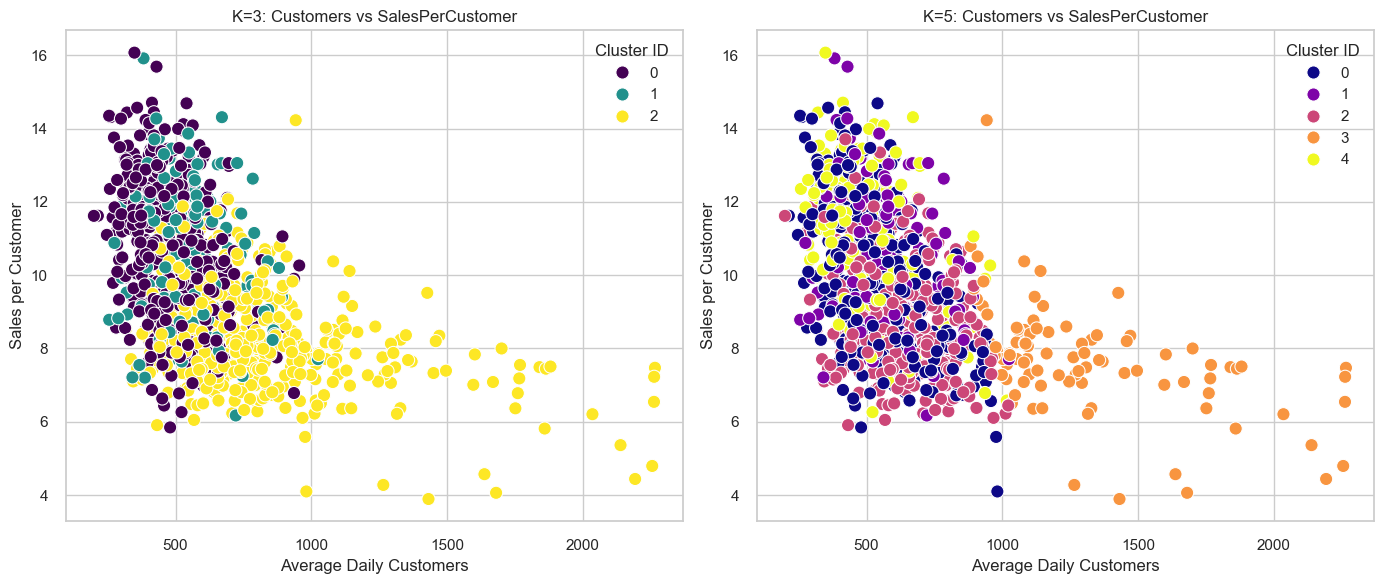

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(
    data=store_data,
    x='Customers',
    y='SalesPerCustomer',
    hue=f'Cluster_{K_3}',
    palette='viridis',
    s=90,
    ax=axes[0],
)
axes[0].set_title(f'K={K_3}: Customers vs SalesPerCustomer')
axes[0].set_xlabel('Average Daily Customers')
axes[0].set_ylabel('Sales per Customer')
axes[0].legend(title='Cluster ID')
axes[0].grid(True)

sns.scatterplot(
    data=store_data,
    x='Customers',
    y='SalesPerCustomer',
    hue=f'Cluster_{K_5}',
    palette='plasma',
    s=90,
    ax=axes[1],
)
axes[1].set_title(f'K={K_5}: Customers vs SalesPerCustomer')
axes[1].set_xlabel('Average Daily Customers')
axes[1].set_ylabel('Sales per Customer')
axes[1].legend(title='Cluster ID')
axes[1].grid(True)

plt.tight_layout()
plt.show()
